In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
import scipy

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [6]:
n_samples = 500
input_dim = 4
d_H = 1
width = 512  # 1024
bias = True
n_steps = 1000
base_lr = 1e-3
p = 4  # p = 2
batch_size = None
tgt_func_name = "target_func"

SEED = 42
pause = 1e-6

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/neurons_dynamic/bias/{}'.format(width))
# FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/standard_nn/{}'.format(width))

In [8]:
set_random_seeds(SEED)

## Set up data, model, loss and optimizer

In [9]:
# val data
X_val = torch.randn(size=(n_samples, input_dim), requires_grad=False)
#target_func = TARGET_FUNCS_DICT['{}_{}d'.format(tgt_func_name, input_dim)]
# y_val = torch.reshape(0.5 * (X_val ** 2).sum(dim=1), (len(X_val), 1))
y_val = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X_val[:, :d_H] ** p).sum(dim=1), 
                      (len(X_val), 1))
# y_val = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X_val ** p).sum(dim=1), (len(X_val), 1))


# loss 
loss = LOSS_DICT['mse'](reduction='mean')

In [10]:
# networks & optimizers

# net 1 = standard
network_1 = torch.nn.Sequential(
    torch.nn.Linear(in_features=input_dim, out_features=width, bias=bias),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=width, out_features=1, bias=bias)
)
with torch.no_grad():
    torch.nn.init.kaiming_normal_(network_1[0].weight.detach(), mode='fan_out', nonlinearity='relu')
    torch.nn.init.kaiming_normal_(network_1[2].weight.detach(), mode='fan_out', nonlinearity='relu')
    
network_1.train()
optimizer_1 = torch.optim.SGD(network_1.parameters(), lr=base_lr)

# net 2 = ip-unif-sphere
network_2 = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network_2.train()
optimizer_2 = torch.optim.SGD(network_2.parameters(), lr=width * base_lr)

# net 3 = ip-unif-ball
network_3 = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network_3.train()
optimizer_3 = torch.optim.SGD(network_3.parameters(), lr=width * base_lr)
with torch.no_grad():
    network_3.initialize_parameters(mode='ball_uniform')
    
# net 4 = Gaussian
network_4 = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network_4.train()
optimizer_4 = torch.optim.SGD(network_4.parameters(), lr=width * base_lr)
with torch.no_grad():
    network_4.initialize_parameters(mode='gaussian')

networks = {'standard': network_1,
            'ip-unif-sphere': network_2,
            'ip-unif-ball': network_3,
            'ip-gaussian': network_4}

optimizers = {'standard': optimizer_1,
              'ip-unif-sphere': optimizer_2,
              'ip-unif-ball': optimizer_3,
              'ip-gaussian': optimizer_4}

## Plot initial neurons

In [11]:
signs = dict()
init_neurons = dict()
for key in ['ip-unif-sphere', 'ip-unif-ball', 'ip-gaussian']:
    signs[key] = networks[key].output_layer.weight.data.detach().clone().numpy()[0]
    init_neurons[key] = networks[key].input_layer.weight.data.detach().clone().numpy()

signs['standard'] = np.sign(networks['standard'][2].weight.data.detach().clone().numpy()[0])
init_neurons['standard'] = networks['standard'][0].weight.data.detach().clone().numpy()

standard


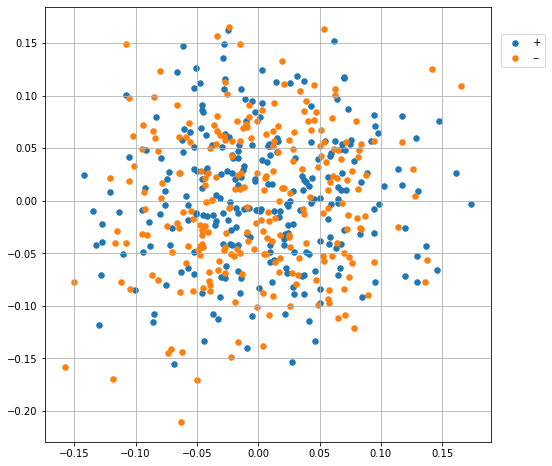



ip-unif-sphere


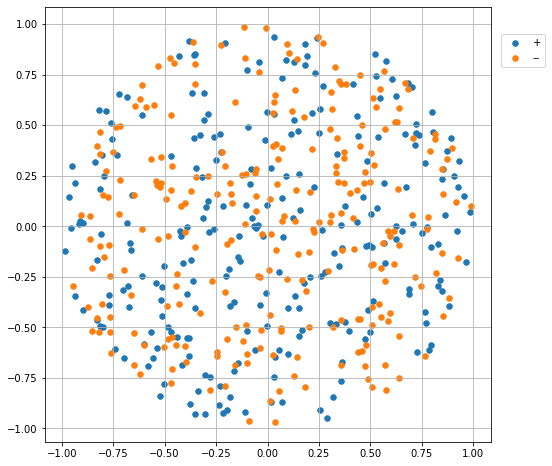



ip-unif-ball


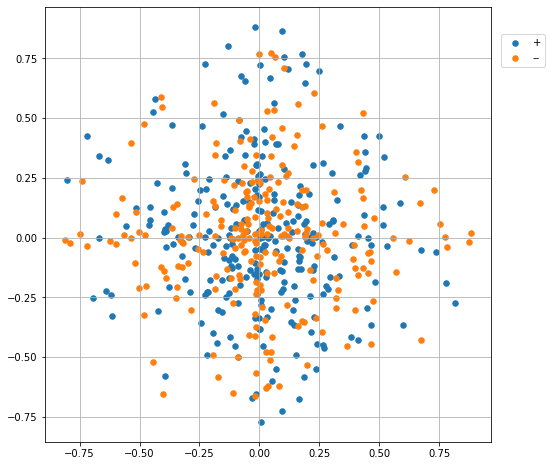



ip-gaussian


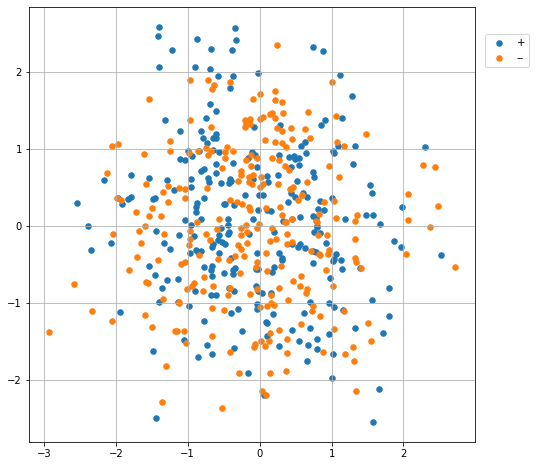

In [12]:
for key in networks.keys():
    print(key)
    fig = plt.figure(figsize=(8,8))
    plot_neurons_2d(fig, init_neurons[key], signs[key], s=30)
    plt.show()
    print('\n')

## Train for a few steps in low dim

In [13]:
all_train_losses = dict()
all_val_losses = dict()
all_neurons = dict()
all_normalized_neurons = dict()

In [14]:
bs = 256
all_Xs = torch.randn(size=((5*n_steps) * bs, input_dim), requires_grad=False)

In [15]:
## IP-model with shpere init
for key in networks.keys():
    if 'ip' in key:
        print('key : {} ...'.format(key))
        network = networks[key]
        optimizer = optimizers[key]
        
        neurons = [network.input_layer.weight.data.detach().clone().numpy()]
        normalized_neurons = [neurons[0] / np.sqrt((neurons[0] ** 2).sum(axis=1, keepdims=True))]
        train_losses = []
        val_losses = []
        
        for i in range(5*n_steps):
            optimizer.zero_grad()
            X = all_Xs[i * bs: (i+1) * bs, :]
            #y = torch.reshape(0.5 * (X ** 2).sum(dim=1), (len(X), 1))
            #y = torch.reshape(0.5 * (X[:, 0] ** 2), (len(X), 1))
            y = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X[:, :d_H] ** p).sum(dim=1),
                              (len(X), 1))
            #y = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X ** p).sum(dim=1), (len(X), 1))

            # forward
            y_hat = network.forward(X)
            # loss_ = loss(y_hat, y)
            loss_ = 0.5 * ((y_hat - y) ** 2).mean()

            # backward and gradient step
            loss_.backward()
            optimizer.step()
            train_losses.append(loss_.detach().item())

            # val
            with torch.no_grad():
                y_hat_val = network.forward(X_val)
                # val_loss = loss(y_hat_val, y_val)
                val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean()
                val_losses.append(val_loss.detach().item())

                neurons_i = network.input_layer.weight.data.detach().clone().numpy()
                neurons.append(neurons_i)
                normalized_neurons.append(neurons_i / np.sqrt((neurons_i ** 2).sum(axis=1, keepdims=True)))

        neurons = np.array(neurons)
        normalized_neurons = np.array(normalized_neurons)
        
        all_neurons[key] = neurons
        all_normalized_neurons[key] = normalized_neurons
        all_train_losses[key] = train_losses
        all_val_losses[key] = val_losses

key : ip-unif-sphere ...
key : ip-unif-ball ...
key : ip-gaussian ...


In [16]:
## Standard NN
key = 'standard'
network = networks[key]
optimizer = optimizers[key]

neurons = [network[0].weight.data.detach().clone().numpy()]
normalized_neurons = [neurons[0] / np.sqrt((neurons[0] ** 2).sum(axis=1, keepdims=True))]
train_losses = []
val_losses = []
for i in range(3*n_steps):
    optimizer.zero_grad()
    X = all_Xs[i * bs: (i+1) * bs, :]
    #y = torch.reshape(0.5 * (X ** 2).sum(dim=1), (len(X), 1))
    #y = torch.reshape(0.5 * (X[:, 0] ** 2), (len(X), 1))
    #y = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X ** p).sum(dim=1), (len(X), 1))
    y = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X[:, :d_H] ** p).sum(dim=1),
                  (len(X), 1))

    # forward
    y_hat = network.forward(X)
    # loss_ = loss(y_hat, y)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean()

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())
    
    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        # val_loss = loss(y_hat_val, y_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean()
        val_losses.append(val_loss.detach().item())
        
        neurons_i = network[0].weight.data.detach().clone().numpy()
        neurons.append(neurons_i)
        normalized_neurons.append(neurons_i / np.sqrt((neurons_i ** 2).sum(axis=1, keepdims=True)))
    
neurons = np.array(neurons)
normalized_neurons = np.array(normalized_neurons)

all_neurons[key] = neurons
all_normalized_neurons[key] = normalized_neurons
all_train_losses[key] = train_losses
all_val_losses[key] = val_losses

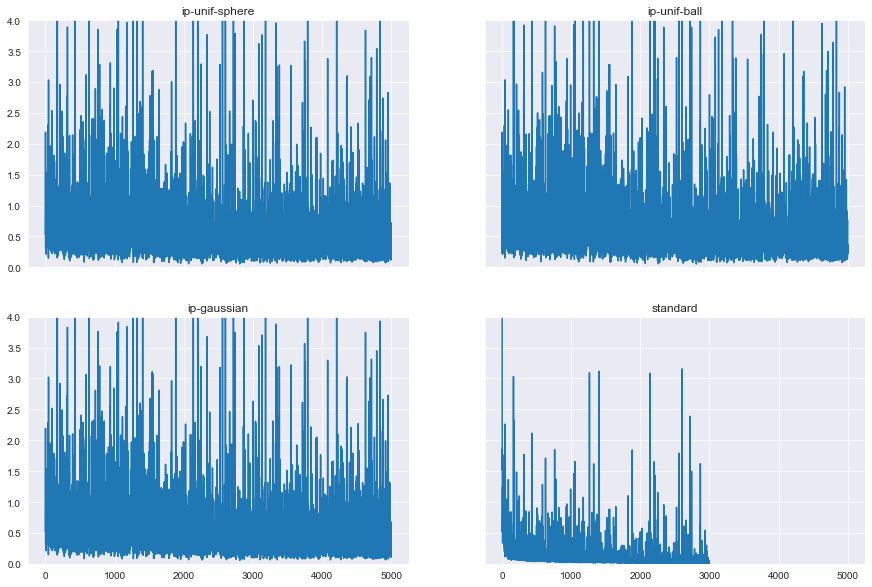

In [17]:
sns.set_style('darkgrid')
n = 5000
fig, axs = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(15,10))
cmpt = 0
plt.ylim(0, 4)
for key, train_losses in all_train_losses.items():
    i, j = divmod(cmpt, 2)
    axs[i][j].plot(np.arange(len(train_losses))[:n], train_losses[:n])
    axs[i][j].set_title(key)
    cmpt += 1
plt.show()

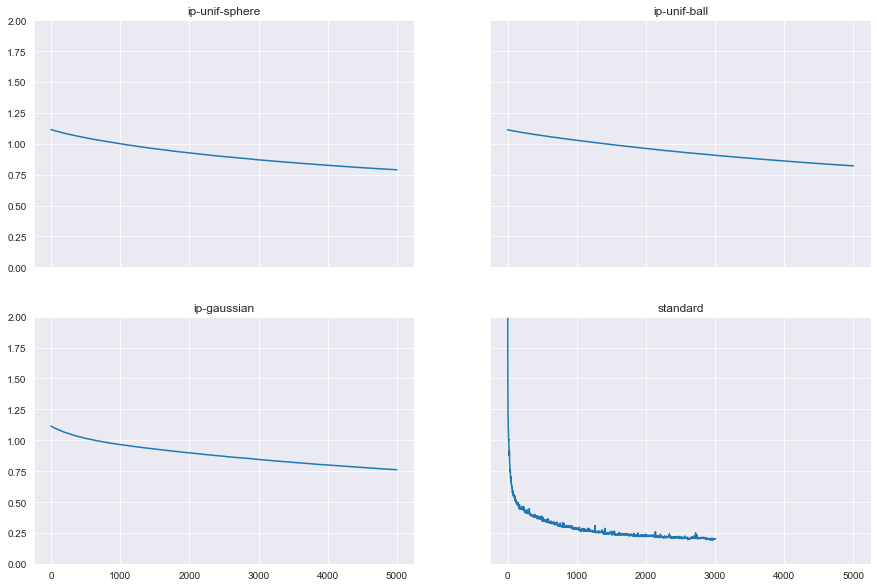

In [18]:
sns.set_style('darkgrid')
n = 5000
fig, axs = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(15,10))
plt.ylim(0, 2)
cmpt = 0
for key, val_losses in all_val_losses.items():
    i, j = divmod(cmpt, 2)
    axs[i][j].plot(np.arange(len(val_losses))[:n], val_losses[:n])
    axs[i][j].set_title(key)
    cmpt += 1
plt.show()

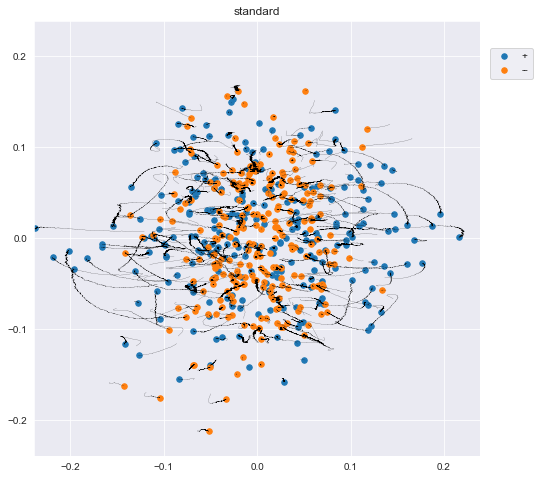

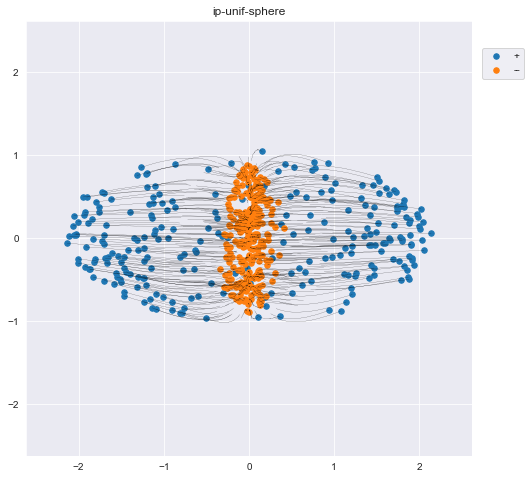

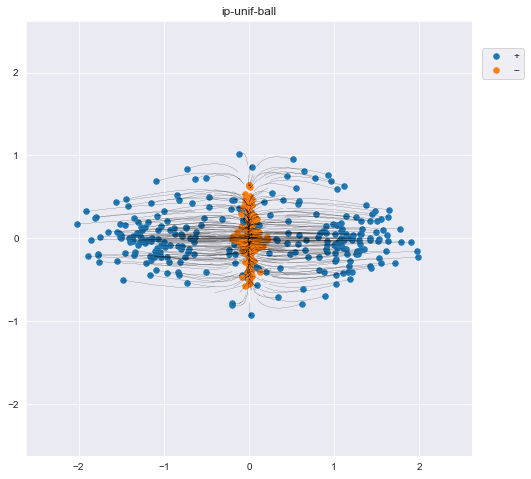

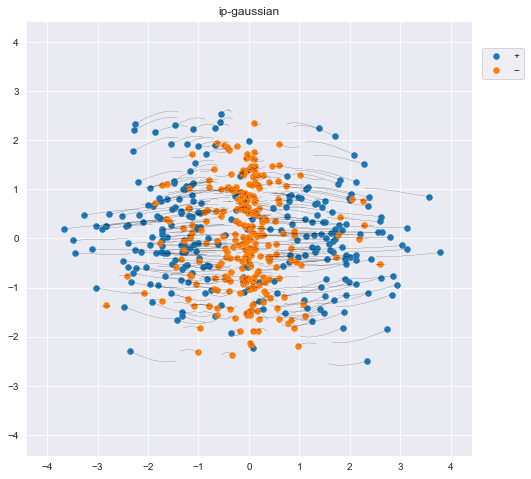

In [19]:
for key in networks.keys():
    neurons = all_neurons[key]
    signs_ = signs[key]
    
    fig = plt.figure(figsize=(8,8))
    plt.title(key)
    M = max(np.max(np.abs(neurons[:, :, 0])), np.max(np.abs(neurons[:, :, 1])))
    plt.xlim(-M, M)
    plt.ylim(-M, M)
    plot_neurons_trajectory_2d(fig, neurons[:3000], signs_, linewidth=0.15, s=30)
    plt.xlim(-M, M)
    plt.ylim(-M, M)
    plt.show()